## Toy Example of HMR

This is the code for reproducing toy example in ICML'19 paper **Heterogeneous Model Reuse via Optimizing Multiparty Multiclass Margin**.

Requirement: Python 3, sklearn, numpy, and matplotlib.

- The first code cell includes all supporting methods, please run it first.
- The second code cell is the main algorithm HMR. Run the main procedure to see how our method performs on generated toy data. Because of randomness, the result will be similar but not exactly the same. You can run the second code cell several times to check this.

Enjoy!

In [1]:
import numpy as np
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import matplotlib
import os
%matplotlib inline

def to_categorical(Y, num_classes):
    n = Y.shape[0]
    Y_one_hot = np.zeros((n, num_classes), np.int)
    for i in range(n):
        Y_one_hot[i, Y[i]] = 1
    return Y_one_hot


def generate_data():
    """Generate the toy data."""
    maxn = 1600
    X = np.zeros((maxn, 2))
    X[:, 0] = np.random.uniform(-1.95, 1.95, maxn)
    X[:, 1] = np.random.uniform(-0.95, 0.95, maxn)
    y = np.zeros(maxn, dtype=np.int)

    idx_list = [None] * 4
    idx_list[0] = (X[:, 0] <= 0) & (X[:, 1] > 0)
    idx_list[1] = (X[:, 0] <= 0) & (X[:, 1] <= 0)
    idx_list[2] = (X[:, 0] > 0) & (X[:, 0] <= 1)
    idx_list[3] = (X[:, 0] > 1)

    for i in range(maxn):
        if ((X[i, 0] - 1) ** 2 + (X[i, 1] - 0.5) ** 2) <= 0.5 ** 2:  # in upper circle
            idx_list[2][i] = True
            idx_list[3][i] = False
        if ((X[i, 0] - 1) ** 2 + (X[i, 1] + 0.5) ** 2) <= 0.5 ** 2:  # in lower circle
            idx_list[2][i] = False
            idx_list[3][i] = True

    for i in range(4):
        y[idx_list[i]] = i

    for i in range(maxn):
        if (y[i] == 0 or y[i] == 1):
            X[i, 0] -= 0.05
            if y[i] == 0:
                X[i, 1] += 0.05
            else:
                X[i, 1] -= 0.05
        if y[i] == 2:
            X[i, 0] += 0.05
            X[i, 1] *= (1 / 0.95)
        if y[i] == 3:
            X[i, 0] += 0.1
            X[i, 1] *= (1 / 0.95)

    maxn_add = int(maxn / 4)
    X_add = np.zeros((maxn_add, 2))
    X_add[:, 0] = np.random.uniform(-2, 2, maxn_add)
    X_add[:, 1] = np.random.uniform(1.01, 1.5, maxn_add)
    y_add = np.array([4] * maxn_add)
    y = np.concatenate((y, y_add), axis=0)
    X = np.concatenate((X, X_add), axis=0)
    Y_multiclass = np.zeros(y.shape, np.int)
    n_class = len(np.unique(y))
    for i in range(n_class):
        Y_multiclass[y == i] = i
    y = Y_multiclass
    random_idx = np.random.permutation(maxn + maxn_add)
    half_idx = int(np.round((maxn + maxn_add) / 2))

    y = y[random_idx]
    X = X[random_idx]
    Y_test = y[half_idx:]
    X_test = X[half_idx:]
    X_train = X[:half_idx]
    Y_train = y[:half_idx]
    return X_train, Y_train, X_test, Y_test


def separate_data(X_train, Y_train):
    """Separate the toy data to three parties."""
    n_class = 5
    c_split = [[0, 1], [2, 3], [3, 4]]

    Y_one_hot = to_categorical(Y_train, n_class)
    idx_LR = Y_train <= c_split[0][1]
    idx_SVM = (Y_train >= c_split[1][0]) & (Y_train <= c_split[1][1])
    idx_GBDT = Y_train >= c_split[2][0]

    X_LR = X_train[idx_LR]
    X_SVM = X_train[idx_SVM]
    X_GBDT = X_train[idx_GBDT]

    Y_LR = Y_one_hot[idx_LR, :c_split[0][1] + 1]
    Y_SVM = Y_one_hot[idx_SVM, c_split[1][0]:c_split[1][1] + 1]
    Y_GBDT = Y_one_hot[idx_GBDT, c_split[2][0]:]
    return X_LR, Y_LR, X_SVM, Y_SVM, X_GBDT, Y_GBDT


class Tunnel():
    """Send and receive examples in the tunnel."""

    def __init__(self, names):
        self.names = names
        self.data = {}
        for sender in names:
            self.data[sender] = {}
            for receiver in names:
                self.data[sender][receiver] = []
        self.sequence = []

    def send(self, sender, receiver, x, y):
        self.data[sender][receiver].append((x, y))
        self.sequence.append((x, y))

    def last_send(self):
        return self.sequence[-1]

    def empty(self):
        if len(self.sequence) == 0:
            return True
        else:
            return False

    def receive(self, receiver):
        received_X = []
        received_y = []
        for sender in self.names:
            received_X.extend([e[0] for e in self.data[sender][receiver]])
            received_y.extend([e[1] for e in self.data[sender][receiver]])
        received_X = np.array(received_X)
        received_y = np.array(received_y)
        return received_X, received_y


class Model_Wrapper_Base():
    """The base class of single model, in order to support reserved class mechanism."""

    def __init__(self, class_name_list):
        self.num_classes = len(class_name_list)
        self.class_name_list = class_name_list
        self.reserved = False
        self.init_model()

    def init_model(self):
        pass

    def fit(self, X, Y):
        if self.reserved == False:
            if Y.shape[1] > self.num_classes:
                self.reserved = True
        self.model.fit(X, np.argmax(Y, axis=1))

    def predict_proba(self, X, remove_reserved_class=True):
        prob_pred = self.model.predict_proba(X)
        if self.reserved and remove_reserved_class:
            return prob_pred[:, :-1]
        else:
            return prob_pred

    def predict_class(self, X, remove_reserved_class=True):
        prob_pred = self.predict_proba(X, remove_reserved_class)
        return np.argmax(prob_pred, axis=1)


# Wrappers of common classifiers, in order to support reserved class mechanism.
class SVM_Wrapper(Model_Wrapper_Base):

    def init_model(self):
        self.model = svm.SVC(kernel='rbf', gamma=2, probability=True, decision_function_shape='ovr')


class LR_Wrapper(Model_Wrapper_Base):

    def init_model(self):
        self.model = LogisticRegression()


class GBDT_Wrapper(Model_Wrapper_Base):

    def init_model(self):
        self.model = GradientBoostingClassifier()


class Model_Pool():
    """Wrap the ensemble of local models, approximating a global model."""

    def label_space_mapping(self):
        self.mapping = []
        for name in self.names:
            self.mapping.append(self.model_pool[name].class_name_list)

    def __init__(self, model_names, model_list, data_list, class_name_lists, all_class_names):
        self.names = model_names
        self.model_pool = {}
        self.data_pool = {}
        for i, name in enumerate(self.names):
            self.model_pool[name] = model_list[i]
            self.data_pool[name] = data_list[i]

        self.class_name_lists = class_name_lists
        self.class_name_list = all_class_names
        self.num_classes = len(self.class_name_list)
        self.label_space_mapping()
        self.data_size = []
        for name in self.names:
            self.data_size.append(self.data_pool[name]['y_train'].shape[0])
        self.full_data_size = sum(self.data_size)
        self.model_weight = np.array(self.data_size) / self.full_data_size

    def random_model(self):
        return np.random.choice(self.names, p=self.model_weight)

    def local_to_global(self, name, y_local):
        """Transform one-hot local label space matrix to global, padding with 0."""
        predict_value = np.zeros((y_local.shape[0], self.num_classes))
        idx = self.names.index(name)
        predict_value[:, self.mapping[idx]] = y_local
        return predict_value

    def global_class_to_local_class(self, name, y_global_class):
        """Transform global class to local class. If out of space, set reserved_flag."""
        y_local_class = np.zeros(y_global_class.shape[0], dtype=np.int)
        class_list = self.model_pool[name].class_name_list
        reserved_class = len(class_list)
        reserved_flag = False
        for i, e in enumerate(y_global_class):
            if e in class_list:
                y_local_class[i] = class_list.index(e)
            else:
                reserved_flag = True
                y_local_class[i] = reserved_class
        return y_local_class, reserved_flag

    def MPMC_margin_batch(self, X, Y):
        n = Y.shape[0]
        margin = np.zeros(n)
        i_pos = [None] * n
        i_neg = [None] * n
        for i in range(n):
            margin[i], i_pos[i], i_neg[i] = self.MPMC_margin(X[i, :], Y[i])
        return (margin, i_pos, i_neg)

    def MPMC_margin(self, x, y):
        """Compute MPMC margin on (x,y)."""
        i_pos = None
        correct_max = 0
        i_neg = None
        incorrect_max = 0
        x = np.expand_dims(x, axis=0)
        for idx, name in enumerate(self.names):
            y_local = self.model_pool[name].predict_proba(x)
            y_global = np.ravel(self.local_to_global(name, y_local))
            if y_global[y] > correct_max:
                i_pos = name
                correct_max = y_global[y]
            y_global[y] = 0
            max_class = np.argmax(y_global)
            max_proba = y_global[max_class]
            if max_proba > incorrect_max:
                i_neg = name
                incorrect_max = max_proba
        margin = correct_max - incorrect_max
        return (margin, i_pos, i_neg)

    def predict_proba(self, X):
        n = X.shape[0]
        predict_value = np.zeros((len(self.names), n, self.num_classes))

        for idx, name in enumerate(self.names):
            y_local = self.model_pool[name].predict_proba(X)
            y_global = self.local_to_global(name, y_local)
            predict_value[idx, :, :] = y_global
        predict_vector = np.max(predict_value, axis=0)
        return predict_vector

    def predict_class(self, X):
        predict_value = self.predict_proba(X)
        return np.argmax(predict_value, axis=1)

    def evaluate(self, X, Y):
        return np.sum(Y == self.predict_class(X)) / Y.shape[0]


def color_map(y):
    # blue, yellow, green, magenta, orange
    colors = ['#0066FF', '#FFCC00', '#33CC33', '#CC00FF', '#FF9933']
    l = [0] * y.shape[0]
    for i in range(len(l)):
        l[i] = colors[y[i]]
    return l


def draw_data_points(X_test, Y_test, figure_type="plot", output_folder=None):
    """Draw the colorful data points"""
    plt.figure(figsize=(4, 3))
    plt.scatter(X_test[:, 0], X_test[:, 1], c=color_map(Y_test), marker='o', edgecolors='None')
    matplotlib.rcParams['axes.linewidth'] = 2
    plt.xlim(-2, 2)
    plt.ylim(-1, 1.5)
    plt.xticks(())
    plt.yticks(())

    if figure_type == 'save':
        if not os.path.exists(output_folder):
            os.mkdir(output_folder)
        path = os.path.join(output_folder, "five_class_data.png")
        plt.savefig(path)
    else:
        print('five class data')
        plt.show()
    plt.close()


def draw_decision_boundary(model_pool, tunnel, step, acc, X_test, figure_type="plot", output_folder=None):
    """Draw the decision boundaries and predicted classes in color"""
    matplotlib.rcParams.update({'font.size': 20})
    matplotlib.rcParams['axes.linewidth'] = 2
    matplotlib.rcParams['lines.linewidth'] = 6
    from matplotlib.colors import LinearSegmentedColormap
    plt.figure(figsize=(4, 3))
    Y_pred = model_pool.predict_class(X_test)

    plt.scatter(X_test[:, 0], X_test[:, 1], c=color_map(Y_pred), marker='o',
                edgecolors='None', s=14, alpha=1)

    plt.axis('tight')
    x_min = -2
    x_max = 2
    y_min = -1
    y_max = 1.5
    n_bins = 5

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = model_pool.predict_class(np.c_[XX.ravel(), YY.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(XX.shape)

    colors = ['#0066FF', '#FFCC00', '#33CC33', '#CC00FF', '#FF9933']
    colors = colors[:n_bins]
    cmap_name = 'my_list'
    custom_cmap = LinearSegmentedColormap.from_list(
        cmap_name, colors, N=n_bins)

    plt.pcolormesh(XX, YY, Z, cmap=custom_cmap)
    plt.contour(XX, YY, Z, colors=['#3B3838'], linestyles=['-'], linewidths=3,
                levels=list(range(0, n_bins)), zorder=1)

    if not tunnel.empty():
        inst, y = tunnel.last_send()
        plt.scatter(inst[0], inst[1],
                    c='r', marker='x', edgecolors='face',
                    s=300, linewidths=4, zorder=2)

    plt.xlim(-2, 2)
    plt.ylim(-1, y_max)
    plt.xticks(())
    plt.yticks(())

    path = os.path.join(output_folder, 'HMR_iter%d_%.4f.png' % (step, acc))
    if figure_type == "save":
        plt.savefig(path)
    else:
        plt.show()
    plt.close()


def calibrate(model_pool, tunnel, receiver):
    """The calibration operation.

    Receiver is the model owner, who updates local model by received examples.
    """
    # get the receiver party's local data
    X = model_pool.data_pool[receiver]['X_train']
    y = model_pool.data_pool[receiver]['y_train']
    n, m = y.shape

    # receive the data from tunnel
    received_X, received_y = tunnel.receive(receiver)
    received_y, reserved_flag = model_pool.global_class_to_local_class(receiver, received_y)

    # augment the local data
    if reserved_flag:
        # set the reserved class of received example and pad zeros to other examples
        received_y = to_categorical(received_y, m + 1)
        y = np.concatenate((y, np.zeros((n, 1))), axis=1)
    else:
        received_y = to_categorical(received_y, m)
    X_augmented = np.concatenate((X, received_X), axis=0)
    y_augmented = np.concatenate((y, received_y), axis=0)

    # retrain local model
    model_pool.model_pool[receiver].fit(X_augmented, y_augmented)



five class data


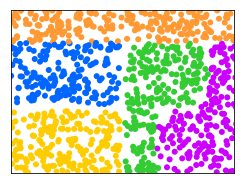

accuracy before running HMR: 0.3120
party i: LR   party i+: LR   party i-: GBDT  class: 1  iter:  0/0     acc: 0.3120


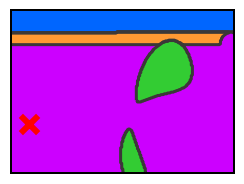

party i: LR   party i+: LR   party i-: GBDT  class: 0  iter:  1/2     acc: 0.5890


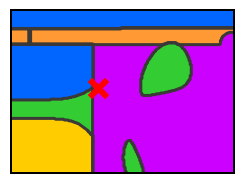

party i: SVM  party i+: SVM  party i-: GBDT  class: 2  iter:  2/3     acc: 0.6170


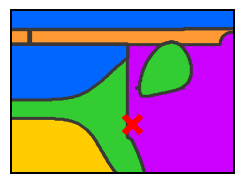

party i: SVM  party i+: SVM  party i-: GBDT  class: 2  iter:  3/4     acc: 0.6830


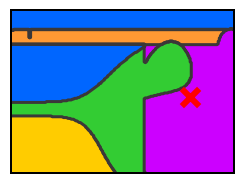

party i: LR   party i+: LR   party i-: SVM   class: 1  iter:  4/17    acc: 0.7380


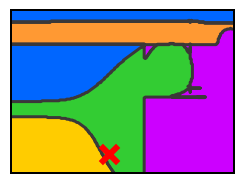

party i: LR   party i+: LR   party i-: SVM   class: 1  iter:  5/18    acc: 0.6740


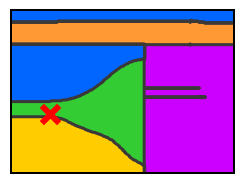

party i: SVM  party i+: SVM  party i-: GBDT  class: 2  iter:  6/27    acc: 0.7530


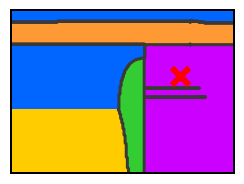

party i: SVM  party i+: SVM  party i-: GBDT  class: 2  iter:  7/28    acc: 0.8660


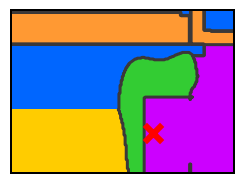

party i: SVM  party i+: SVM  party i-: GBDT  class: 2  iter:  8/30    acc: 0.8990


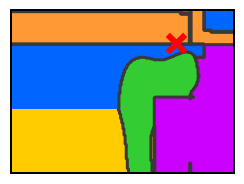

party i: SVM  party i+: SVM  party i-: LR    class: 2  iter:  9/34    acc: 0.8930


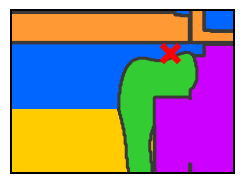

party i: SVM  party i+: SVM  party i-: GBDT  class: 2  iter: 10/47    acc: 0.9400


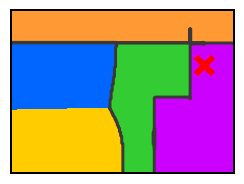

party i: SVM  party i+: SVM  party i-: GBDT  class: 2  iter: 11/50    acc: 0.9680


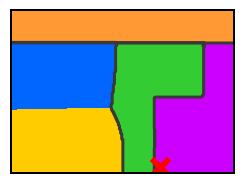

party i: SVM  party i+: SVM  party i-: GBDT  class: 2  iter: 12/330   acc: 0.9840


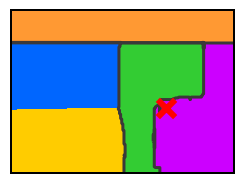

party i: LR   party i+: LR   party i-: SVM   class: 0  iter: 13/344   acc: 0.9880


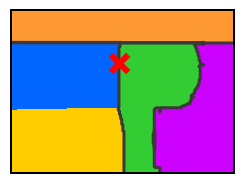

party i: SVM  party i+: SVM  party i-: GBDT  class: 2  iter: 14/345   acc: 0.9880


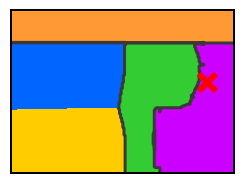

party i: SVM  party i+: SVM  party i-: GBDT  class: 2  iter: 15/417   acc: 0.9920


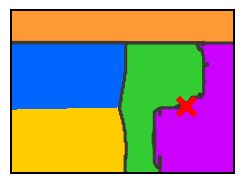

party i: SVM  party i+: SVM  party i-: GBDT  class: 2  iter: 16/454   acc: 0.9920


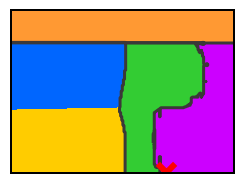

party i: SVM  party i+: SVM  party i-: GBDT  class: 2  iter: 17/699   acc: 0.9930


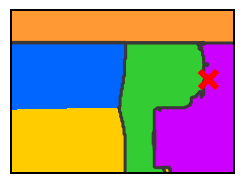

party i: SVM  party i+: SVM  party i-: GBDT  class: 2  iter: 18/707   acc: 0.9950


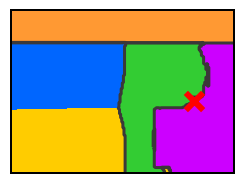

party i: SVM  party i+: SVM  party i-: LR    class: 2  iter: 19/731   acc: 0.9920


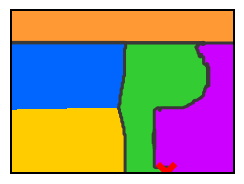

party i: SVM  party i+: SVM  party i-: GBDT  class: 2  iter: 20/907   acc: 0.9930


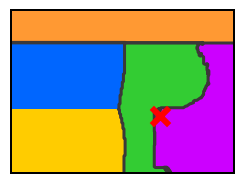

party i: SVM  party i+: SVM  party i-: GBDT  class: 2  iter: 21/1679  acc: 0.9980


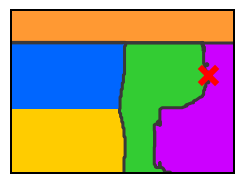

party i: SVM  party i+: SVM  party i-: GBDT  class: 2  iter: 22/2246  acc: 0.9990


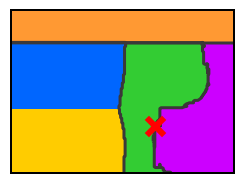

party i: SVM  party i+: SVM  party i-: GBDT  class: 2  iter: 23/3213  acc: 0.9990


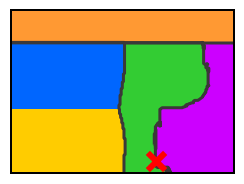

party i: SVM  party i+: SVM  party i-: LR    class: 2  iter: 24/4093  acc: 1.0000


In [ ]:
# FIGURE_TYPE = 'save' will save figures into OUTPUT_IMG_FOLDER, 
# FIGURE_TYPE = 'plot' will plot figures below
# if you want to see cleaner print information, set it to 'save'
FIGURE_TYPE = "plot" 
OUTPUT_IMG_FOLDER = 'HMR_toy_example_figures'

# Generate and plot toy data
X_train, Y_train, X_test, Y_test = generate_data()
draw_data_points(X_test, Y_test, FIGURE_TYPE, OUTPUT_IMG_FOLDER)

# Each party observes partial data
X_LR, Y_LR, X_SVM, Y_SVM, X_GBDT, Y_GBDT = separate_data(X_train, Y_train)

# Intialize the local models, and train them locally
all_class_names = [0, 1, 2, 3, 4]
class_name_lists = [[0, 1], [2, 3], [3, 4]]

LR_model = LR_Wrapper(class_name_lists[0])
LR_model.fit(X_LR, Y_LR)
SVM_model = SVM_Wrapper(class_name_lists[1])
SVM_model.fit(X_SVM, Y_SVM)
GBDT_model = GBDT_Wrapper(class_name_lists[2])
GBDT_model.fit(X_GBDT, Y_GBDT)

# Intialize an ensemble of models, which is model_pool
names = ['LR', 'SVM', 'GBDT']
model_list = [LR_model, SVM_model, GBDT_model]
data_list = [{'X_train': X_LR, 'y_train': Y_LR},
             {'X_train': X_SVM, 'y_train': Y_SVM},
             {'X_train': X_GBDT, 'y_train': Y_GBDT}]
model_pool = Model_Pool(names, model_list, data_list, class_name_lists, all_class_names)

# Initialize tunnel, which contains all the shared examples
tunnel = Tunnel(names)

# Evaluate the accuracy before running our method
accuracy = model_pool.evaluate(X_test, Y_test)
print('accuracy before running HMR: %.4f' % accuracy)

# Set parameters
inner_iter_counter = 0
BUDGET = 50
MAX_STEP = 10000

# HMR main procedure
for step in range(0, MAX_STEP):
    if inner_iter_counter >= BUDGET:
        print("out of budget")
        break
    # Sample a party i
    party_i = model_pool.random_model()

    # Randomly select an example (x,y) from party i's local data set
    local_data = model_pool.data_pool[party_i]
    X = local_data['X_train']
    Y = local_data['y_train']
    random_example_idx = np.random.randint(X.shape[0])
    x = X[random_example_idx, :]
    y = model_pool.local_to_global(party_i, Y[random_example_idx, :])  # convert to global label space
    y = np.argmax(y)  # one-hot encoding to multi-class label

    # Compute the MPMC_margin on (x,y)
    margin, i_pos, i_neg = model_pool.MPMC_margin(x, y)

    if margin <= 0:  # non-positive margin found
        print('party i: %-4s party i+: %-4s party i-: %-4s  class: %d  iter: %2d/%-4d  acc: %.4f' %
              (party_i, i_pos, i_neg, y, inner_iter_counter, step, accuracy))

        # Send the selected example from party i to party i_pos/i_neg
        tunnel.send(party_i, i_pos, x, y)
        tunnel.send(party_i, i_neg, x, y)

        # Draw the decision boundaries
        # If FIGURE_TYPE=='save', these figures will be saved to folder OUTPUT_IMG_FOLDER
        draw_decision_boundary(model_pool, tunnel, inner_iter_counter, accuracy,
                               X_test, FIGURE_TYPE, OUTPUT_IMG_FOLDER)

        # Receive and do calibration operation
        calibrate(model_pool, tunnel, i_pos)
        calibrate(model_pool, tunnel, i_neg)

        # Evaluate the test accuracy
        accuracy = model_pool.evaluate(X_test, Y_test)
        inner_iter_counter += 1


if step == MAX_STEP - 1:
    print('converged')